# Single cosine distance classifier vs Ensemble of 4 classifiers 

### Load data and packages

The directory data  already exists
The directory output  already exists


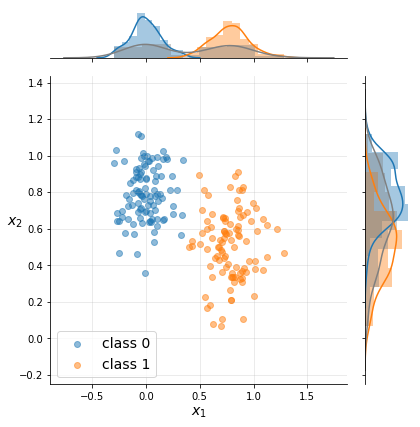

In [7]:
import sys

sys.path.insert(1, '../')

from Utils import *
from modeling import *

create_dir('data')
create_dir('output')

seed = 2

np.random.seed(seed)

X, y = load_data(centers=[[.0, .8], [.8, .5]], n=200, std=[.15, .2])

### Split data in training and test

In [8]:
test_size = .1
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

Y_vector_train = label_to_array(y_train)
Y_vector_test = label_to_array(y_test)

print("Size Training Set: ", len(X_train))
print("Size Test Set: ", len(X_test))

n_shots = 100

Size Training Set:  180
Size Test Set:  20


### Choose device

In [9]:
from qiskit import IBMQ

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
real_device = provider.get_backend('ibmq_qasm_simulator')

C:\Users\anton\Anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


### Quantum cosine classifier for all the observations of the test set

In [4]:
accuracy = []
n_shots = 100

for i in range(10):
    #initialisation
    n = range(len(X_train))
    TP = 0
    predictions = []
    probabilities = []

    for x_test, y_ts in zip(X_test, Y_vector_test):
        ix = np.random.choice(n, 1)[0]
        x_train = X_train[ix]
        x_tr = normalize_custom(x_train)
        y_tr = Y_vector_train[ix]
        x_ts = normalize_custom(x_test)

        qc = cos_classifier(x_tr, x_ts, y_tr)
        r = exec_simulator(qc, n_shots=n_shots)

        if '0' not in r.keys():
            r['0'] = 0
        elif '1' not in r.keys():
            r['1'] = 0

        p0 = (r['0'] / (r['0'] + r['1']))
        p0 = p0
        p1 = 1 - p0

        predictions.append(r)
        probabilities.append(predict_cos(r))
        probs = [p0, p1]


        if predict_cos(r)[0] > predict_cos(r)[1]:
            pred = [1, 0]
            pred = np.asarray(pred)
        else:
            pred = [0, 1]
            pred = np.asarray(pred)

        if np.array_equal(pred, y_ts):
            TP = TP + 1

    accuracy.append(TP / len(X_test))

print('AVG Accuracy multiple cosine classifier:', np.mean(accuracy))
print('STD Accuracy multiple cosine classifier:', np.std(accuracy))

print(qc)

AVG Accuracy multiple cosine classifier: 0.6
STD Accuracy multiple cosine classifier: 0.09219544457292887
              ┌─────────────────────────────┐ ░               ░         
x_train_0: |0>┤ Initialize(0.96628,0.25748) ├─░───────X───────░─────────
              ├─────────────────────────────┤ ░       │       ░         
 x_test_0: |0>┤ Initialize(0.86799,0.49658) ├─░───────X───────░─────────
              └─────┬─────────────────┬─────┘ ░       │       ░         
y_train_0: |0>──────┤ Initialize(0,1) ├───────░───────┼───────░───■─────
                    └─────────────────┘       ░ ┌───┐ │ ┌───┐ ░ ┌─┴─┐┌─┐
 y_test_0: |0>────────────────────────────────░─┤ H ├─■─┤ H ├─░─┤ X ├┤M├
                                              ░ └───┘   └───┘ ░ └───┘└╥┘
    c199_0: 0 ════════════════════════════════════════════════════════╩═
                                                                        


In [6]:
for x_test, y_ts in zip(X_test, Y_vector_test):

    X_data, Y_data = training_set(X_train, y_train, n=4)
    x_test = normalize_custom(x_test)

    qc = ensemble(X_data, Y_data, x_test, n_swap=1, d=2, balanced=True)
    r = exec_simulator(qc, n_shots=n_shots)
    
    # job = execute(qc, real_device, shots = n_shots)
    # results = job.result()
    #r = results.get_counts(qc)

    predictions.append(retrieve_proba(r))
    print(retrieve_proba(r), y_ts)

..\Utils.py:270: ComplexWarning: Casting complex values to real discards the imaginary part
  X_data[i] = normalize_custom(X_data[i])


[0.62, 0.38] [1 0]
[0.64, 0.36] [1 0]
[0.58, 0.42000000000000004] [1 0]
[0.35, 0.65] [0 1]
[0.52, 0.48] [0 1]
[0.67, 0.32999999999999996] [1 0]
[0.58, 0.42000000000000004] [1 0]
[0.48, 0.52] [1 0]
[0.71, 0.29000000000000004] [1 0]
[0.58, 0.42000000000000004] [1 0]
[0.71, 0.29000000000000004] [1 0]
[0.25, 0.75] [0 1]
[0.66, 0.33999999999999997] [1 0]
[0.32, 0.6799999999999999] [0 1]
[0.4, 0.6] [0 1]
[0.31, 0.69] [0 1]
[0.77, 0.22999999999999998] [1 0]
[0.43, 0.5700000000000001] [0 1]
[0.55, 0.44999999999999996] [1 0]
[0.31, 0.69] [0 1]


In [5]:
a, b = evaluation_metrics(predictions, X_test, y_test)
#print(qc)

AttributeError: 'dict' object has no attribute 'rint'

In [ ]:
retrieve_proba(r)

In [ ]:
for x_test, y_ts in zip(X_test, Y_vector_test):

    X_data, Y_data = training_set(X_train, y_train, n=2)
    x_test = normalize_custom(x_test)

    qc = ensemble(X_data, Y_data, x_test, n_swap=1, d=1, balanced=True)
    r = exec_simulator(qc, n_shots=n_shots)
    
    # job = execute(qc, real_device, shots = n_shots)
    # results = job.result()
    #r = results.get_counts(qc)

    predictions.append(retrieve_proba(r))
    print(retrieve_proba(r), y_ts)

In [ ]:
a, b = evaluation_metrics(predictions, X_test, y_test)
print(qc)